# lora parsing matlab translation

In [1]:
import pathlib
import numpy as np
import re
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

import altair as alt
import pandas as pd

## util functions 

In [2]:
def _extract_digit(pattern, text):
    """ helper for extract_bw_and_sf """
    try:
        match = int(re.search(pattern, text)[1])
    except:
        print('ERROR! unable to extract bw or sf')
        return 
    else:
        return match 
    
    
def extract_bw_and_sf(filename):
    """ extracts params from input filename """
    _bw_pattern, _sf_pattern = r'BW(\d)', r'SF(\d{1,})'
    
    bw_match = _extract_digit(_bw_pattern, filename)
    if bw_match is not None:
        bw_match = BW_val[bw_match - 1]
    
    sf_match = _extract_digit(_sf_pattern, filename)
    
    return bw_match, sf_match



## setup

In [3]:
# data file
DATA_FILE = pathlib.Path('data/LoRa_Recording_OTA/Location0/lora_BW9_SF11_915MHz_1Msps_L0.dat')

# BW and SF setup
BW_val = np.array([10.4e3, 15.6e3, 0, 0, 0, 0, 125e3,250e3,500e3])
BW, SF = extract_bw_and_sf(DATA_FILE.name)
print(f'BW: {BW} | SF: {SF}')

# signal
s = np.fromfile(DATA_FILE, dtype=np.complex64)
N = s.size
print(f'loaded {N} samples from {DATA_FILE.name}')

# constants
Fs = 1e6
lb = 12
numSampsP = 17770
numSymbols = 8

# computed constants 
sampPerSym = round( ((2**SF) / BW) * Fs )
pcktLen = round( 30.2 * sampPerSym )
print(f'samples per symbol: {sampPerSym} | packet length: {pcktLen}')

padding = np.zeros(numSampsP)
print(f'set padding length: {padding.size}')



BW: 500000.0 | SF: 11
loaded 132410421 samples from lora_BW9_SF11_915MHz_1Msps_L0.dat
samples per symbol: 4096.0 | packet length: 123699.0
set padding length: 17770


## signal normalization

In [4]:
real_s = np.real(s)

th = 0.0005

norm_s = np.array([
    np.ceil(val) if val > th else np.floor(val) if val < -th else 0
    for val in real_s[:10_000_000]
])

## exploration 

In [5]:
def plot_together(subset):
    start, stop = subset 
    
    
    plt.subplot(2,1,1)
    plt.plot(real_s[start:stop])
    plt.subplot(2,1,2)
    plt.plot(norm_s[start:stop])
    

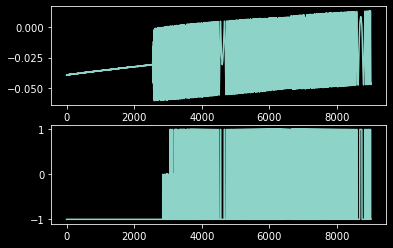

In [6]:
plot_together((1000,10000))

In [7]:
zero_idxs = np.where(norm_s == 0)[0]
zero_idxs.size

1334207

In [8]:
diff_zi = np.diff(zero_idxs)
diff_zi

array([ 45,  19,  35, ...,  12,  17, 197])

In [9]:
diff_zi[:50]

array([ 45,  19,  35,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,  37,   4,  47,  13,   4,  31,  22,   9,  14,
        28,   9,  38,  15,  24,   5,  31,  15,  32,  37,   6,  28,   5,
        23,  24,  23,  62,  13,  13,  14,  26, 102,  22,  41])

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

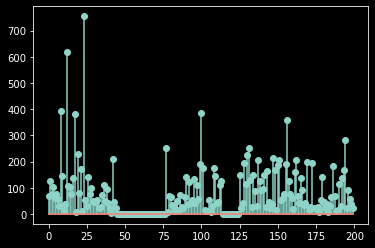

In [10]:
plt.stem(diff_zi[800:1000])

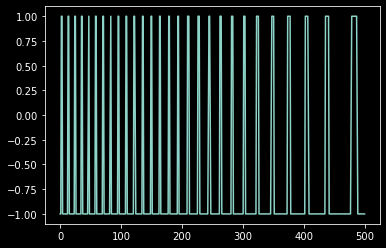

In [11]:
plt.plot(norm_s[5000:5500])

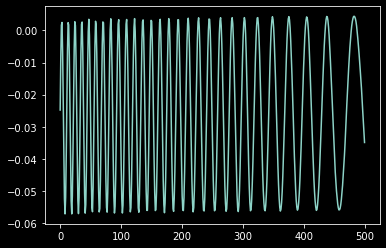

In [12]:
plt.plot(real_s[5000:5500])

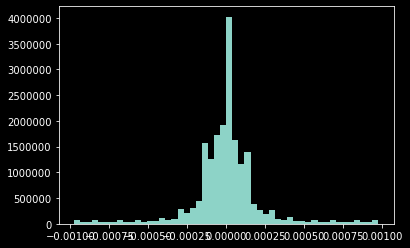

In [13]:
plt.hist(real_s[np.where(abs(real_s) < 1e-3)], bins=50);

In [14]:
import more_itertools as mit
x = [list(j) for j in mit.consecutive_groups(sorted(list(set(zero_idxs))))]

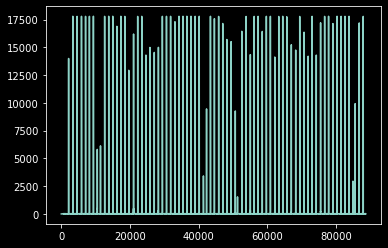

In [15]:
plt.plot(np.array([len(item) for item in x]))

In [ ]:
def _find_max_consecutive(series: pd.Series, threshold: int) -> int:
    """
    takes indices of values > threshold, adds a zero the start of the array
    and a 16 to the end, ensuring the entire range is reprsented
    and then diffs the array element-wise with an offset of 1

    the result is an array of consecutive seconds where the valve
    is <= threshold

    parameters
    ----------
    series : pd.Series
        pandas series containing sequence of values
    threshold : int or float
        the threshold value to compare (values > threshold)

    returns
    -------
    max_consecutive_length : int
        returns an integer representing the maximum consecutive
        count of sequential values <= threshold

    """

    return np.diff(
                series.loc[lambda x: x > threshold].index.values,
        ).max()


## plot test

In [ ]:
start, stop = int(145.4e3), int(145.4e3+4096)

fft_s = np.abs(np.fft.fftshift(np.abs(np.fft.fft(s[start:stop]))))

plt.subplot(2,1,1)
plt.plot(s[start:stop])
plt.subplot(2,1,2)
plt.plot(fft_s)